<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e2?scriptVersionId=163664854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="border: 3px solid yellow; border-radius: 30px; color: white; background-image: url(https://www.kaggle.com/competitions/68479/images/header); padding: 1px 5px 5px 5px">Multi-Class Prediction of Obesity Risk</span>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv
/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv


![](https://www.kaggle.com/competitions/68479/images/header)

# <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 50px;">Table of Contents</span>

1. [Import libraries](#1)
2. [Open data files](#2)
3. [Show first 5 lines of train data](#3)
    - 3.1 [Compare original train and competition train](#3.1)
    - 3.2 [Concatenate original train with competition train](#3.2)
4. [Shapes of train and test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Feature Engineering](#7)
    - 7.1 [Figure out how much duplicates in data](#7.1)
    - 7.2 [Remove duplicates from data](#7.2)
    - 7.3 [One-hot encoding](#7.3)
    - 7.4 [More plots](#7.4)
8. [Display histograms of distribution](#8)
9. [Let's count target of train data](#9)
10. [Transform the data with logarithm](#10)
    - 10.1 [Pie plot of target](#10.1)
    - 10.2 [Feature importance](#10.2)
11. [Build a heat map of correlations](#11)
12. [Define base models with tuned hyperparameters](#12)
13. [Defining the meta-model with tuned hyperparameters](#13)
14. [Creating and fitting the stacking model](#14)
15. [Predict validation set and calculate accuracy score](#15)
16. [Predict the test data](#16)
17. [Build DataFrame and make submission](#17)
18. [Save the model into pickle file](#18)

### <p style="color: #3cb371; border-style: solid; border-color: yellow; padding: 5px 5px 5px 5px; border-width: 5px;">The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition , data was collected using a web platform with a survey where anonymous users answered each question, then the information was processed obtaining 17 attributes and 2111 records</p>

### <p style="color: orange; border-style: solid; border-color: yellow; padding: 5px 5px 5px 5px; border-width: 5px;">The attributes related with eating habits are: Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS)</p>

## <span style="color: #3cb371; border-style: solid; padding: 5px 5px 5px 5px; border-width: 5px;">Features:</span>

**Gender**, **Age**, **Height**, **Weight** are physical attributes

**family_history_with_overweight** points out to familiarity with obesity

**FAVC** - Frequent consumption of high caloric food

**FCVC** - Frequency of consumption of vegetables

**NCP** - Number of main meals

**CAEC** - Consumption of food between meals

**SMOKE** - tobacco usage

**CH20** - Consumption of water daily

**SCC** - Calories consumption monitoring

**FAF** - Physical activity frequency

**TUE** - Time using technology devices

**CALC** - Consumption of alcohol

**MTRANS** - Transportation used

![](https://athleanx.com/wp-content/uploads/2023/07/men-bodyfat-percent.jpg)

<a id='1'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc;background-color: #fadb8c;">🏃‍♀️ 1 - Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from IPython.core.display import HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

<a id='2'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏃‍♂️ 2 - Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

<a id='3'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏋️‍♀️ 3 - Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<a id='3.1'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.1 Compare original train and competition train

In [5]:
print(original_train.shape)
original_train.columns.tolist()

(2111, 17)


['Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [6]:
print(train.shape)
train.columns.tolist()

(20758, 18)


['id',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

##### We have to drop 'id' from train and test dataset

In [7]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

<a id='3.2'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.2 Concatenate original train with competition train

In [8]:
train = pd.concat(objs=[train, original_train])
train.shape

(22869, 17)

##### Now You can see that train data became +2111 objectives bigger than previous data

<a id='4'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🚶‍♂️ 4 - Shapes of train and test data</span>

In [9]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (22869, 17)
Test data: (13840, 16)

Train data consists of 62.3% of all observations
Test data consists of 37.7% of all observations


<a id='5'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍔 5 - Display descriptive statistics of train data</span>

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,22869.0,23.885263,5.753419,14.00,20.000000,22.815416,26.000000,61.00
Height,22869.0,1.700377,0.087881,1.45,1.631662,1.700000,1.763029,1.98
Weight,22869.0,87.767610,26.364243,39.00,66.000000,84.000000,111.531208,173.00
FCVC,22869.0,2.443428,0.533329,1.00,2.000000,2.392665,3.000000,3.00
NCP,22869.0,2.754344,0.712711,1.00,3.000000,3.000000,3.000000,4.00
CH2O,22869.0,2.027442,0.608901,1.00,1.755907,2.000000,2.535127,3.00
FAF,22869.0,0.984382,0.839466,0.00,0.015860,1.000000,1.596576,3.00
TUE,22869.0,0.620551,0.602850,0.00,0.000000,0.579541,1.000000,2.00


In [11]:
contains_inf = train.isin([np.inf, -np.inf]).any().any()
contains_inf

False

##### There is no any inf values

In [12]:
train.describe(include='object').T

,count,unique,top,freq
Gender,22869,2,Female,11465
family_history_with_overweight,22869,2,yes,18740
FAVC,22869,2,yes,20848
CAEC,22869,4,Sometimes,19294
SMOKE,22869,2,no,22580
SCC,22869,2,no,22086
CALC,22869,4,Sometimes,16467
MTRANS,22869,5,Public_Transportation,18267
NObeyesdad,22869,7,Obesity_Type_III,4370


<a id='6'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥞 6 - Check the number of gaps for each feature</span>

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64



TEST data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                    

#### There is no any gaps in values

![](https://www.stylecraze.com/wp-content/themes/buddyboss-child/images/man-body-mass-index-vector.jpg)

<a id='7'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍕 7 - Feature Engineering</span>

### [Features below](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/473220) were created by [LUCA MASSARON](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/473220). I just use them

### <span style="color: #3cb371">Body Mass Index (BMI):</span>
The initial step involved calculating the BMI using the 'Height' and 'Weight' features. BMI, a widely recognized metric, indicates obesity by providing a more accurate representation of the relationship between an individual's weight and height.

### <span style="color: #3cb371">Meal Habits:</span>
The combination of 'FCVC' (Frequency of consumption of vegetables) and 'NCP' (Number of main meals) created the 'Meal_Habits' feature. This feature seeks to encapsulate overall dietary patterns, considering both the frequency of vegetable consumption and the number of main meals.

### <span style="color: #3cb371">Tech Usage Score:</span>
A comprehensive score was crafted by weighting the frequency of technology usage ('TUE') by the individual's age. The resulting 'Tech_Usage_Score' aims to quantify the average time spent using technology relative to the person's age, providing a nuanced perspective on technology habits.

In [14]:
# train['BMI'] = train['Weight'] / (train['Height'] ** 2)
# test['BMI'] = test['Weight'] / (test['Height'] ** 2)

# train['Meal_Habits'] = train['FCVC'] * train['NCP']
# test['Meal_Habits'] = test['FCVC'] * test['NCP']

# train['Tech_Usage_Score'] = train['TUE'] / train['Age']
# test['Tech_Usage_Score'] = test['TUE'] / test['Age']

In [15]:
train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,2.443428,2.754344,2.027442,0.984382,0.620551
std,5.753419,0.087881,26.364243,0.533329,0.712711,0.608901,0.839466,0.602850
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631662,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.392665,3.000000,2.000000,1.000000,0.579541
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.535127,1.596576,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [16]:
train.isin([np.inf, -np.inf]).sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

#### <span style="color: #03adfc">Save data with feature engineering

In [17]:
train.to_csv("PS4E2_train_feature_engineering.csv")
test.to_csv("PS4E2_test_feature_engineering.csv")

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22869 non-null  object 
 1   Age                             22869 non-null  float64
 2   Height                          22869 non-null  float64
 3   Weight                          22869 non-null  float64
 4   family_history_with_overweight  22869 non-null  object 
 5   FAVC                            22869 non-null  object 
 6   FCVC                            22869 non-null  float64
 7   NCP                             22869 non-null  float64
 8   CAEC                            22869 non-null  object 
 9   SMOKE                           22869 non-null  object 
 10  CH2O                            22869 non-null  float64
 11  SCC                             22869 non-null  object 
 12  FAF                             22869 

##### Therer are 8 features with float values and 9 features which are objects (strings)

### Let's draw pie plot for each categorical features

Gender
Female    11465
Male      11404
Name: count, dtype: int64 




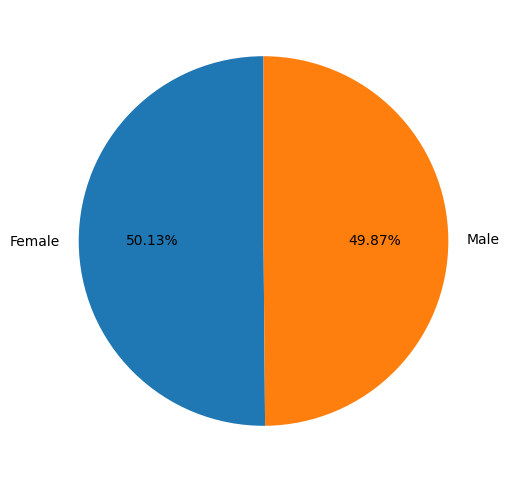

family_history_with_overweight
yes    18740
no      4129
Name: count, dtype: int64 




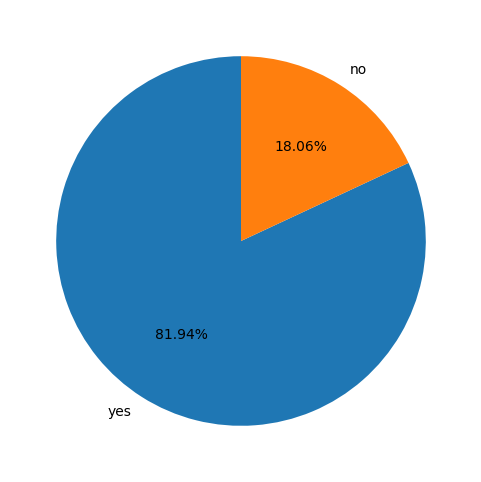

FAVC
yes    20848
no      2021
Name: count, dtype: int64 




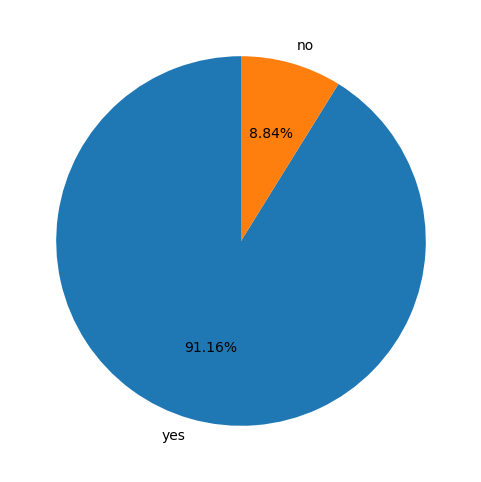

SMOKE
no     22580
yes      289
Name: count, dtype: int64 




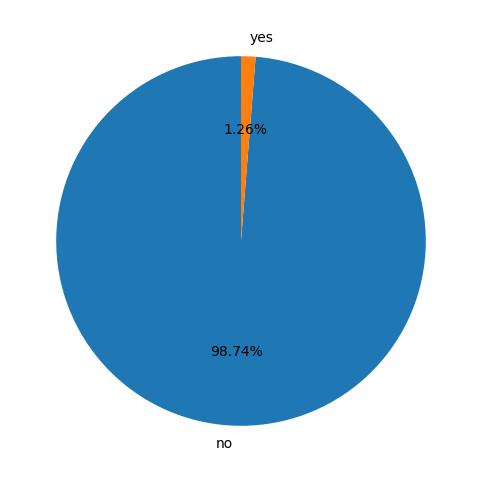

SCC
no     22086
yes      783
Name: count, dtype: int64 




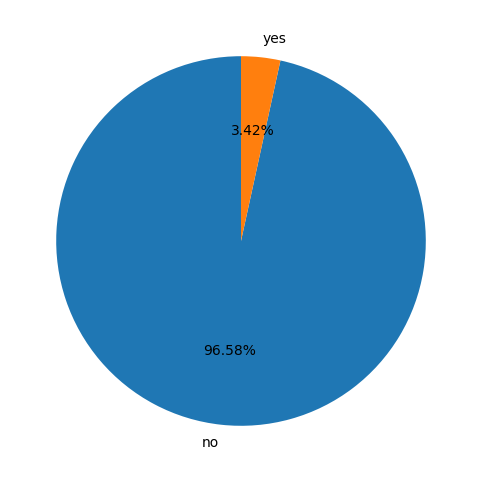

CALC
Sometimes     16467
no             5802
Frequently      599
Always            1
Name: count, dtype: int64 




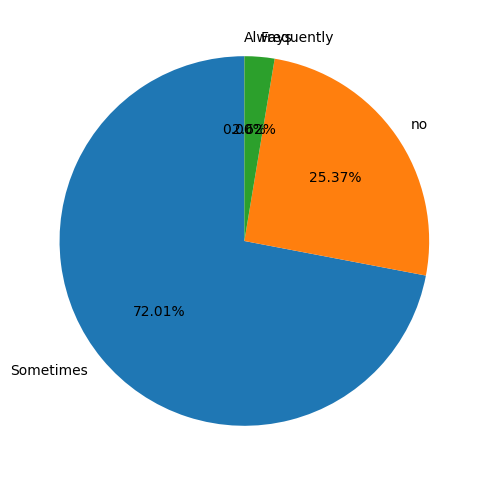

MTRANS
Public_Transportation    18267
Automobile                3991
Walking                    523
Motorbike                   49
Bike                        39
Name: count, dtype: int64 




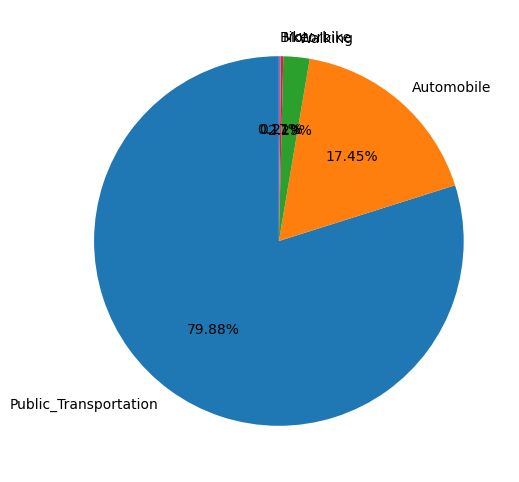

In [19]:
for feature in ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']:
    plt.figure(figsize=(20, 6))
    aggregation = train[feature].value_counts()
    print(aggregation, '\n\n')
    plt.pie(x=aggregation, labels=aggregation.index, autopct='%1.2f%%', startangle=90)
    plt.show()

<a id="7.1"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.1 Figure out how much duplicates in data

In [20]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

24
0


##### There are 24 duplicates in train data. Let's remove them!

<a id="7.2"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.2 Remove duplicates from data

In [21]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
print(len(train_duplicates))

0


##### As we see now there is no more duplicates!

<a id="7.3"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.3 One-hot encoding

In [22]:
# Split the train data into X and y
X = train.drop(['NObeyesdad'], axis=1)
X = pd.get_dummies(X, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0


In [23]:
# Encode target classes
enc = OrdinalEncoder()
train['NObeyesdad'] = enc.fit_transform(train['NObeyesdad'].values.reshape(-1, 1))
y = train.NObeyesdad
y[:10]

0    6.0
1    1.0
2    0.0
3    4.0
4    6.0
5    0.0
6    3.0
7    3.0
8    5.0
9    4.0
Name: NObeyesdad, dtype: float64

<a id="7.4"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.4 More plots

In [24]:
# Features splitted into two groups
categorical_features = [
    'Gender', 
    'family_history_with_overweight', 
    'FAVC', 
    'CAEC',
    'SMOKE',
    'SCC',
    'CALC',
    'MTRANS',  
]

continuous_features = [
    'Age',
    'Height',
    'Weight',
    'FCVC',
    'NCP',
    'CH2O',
    'FAF',
    'TUE',
#     'BMI',
#     'Meal_Habits',
#     'Tech_Usage_Score'
]

target = 'NObeyesdad'

#### We will not use sns.lineplot() because there is no time-series data

## <span style="color: #03adfc">Barplot



Feature: Age


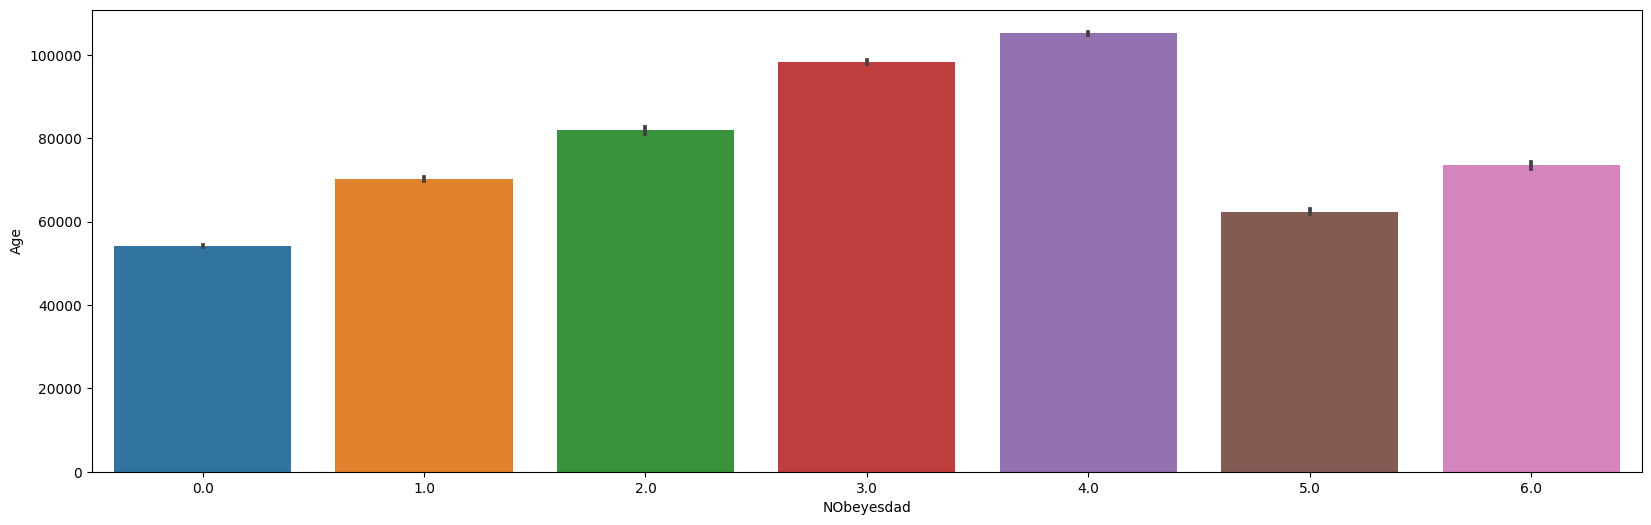



Feature: Height


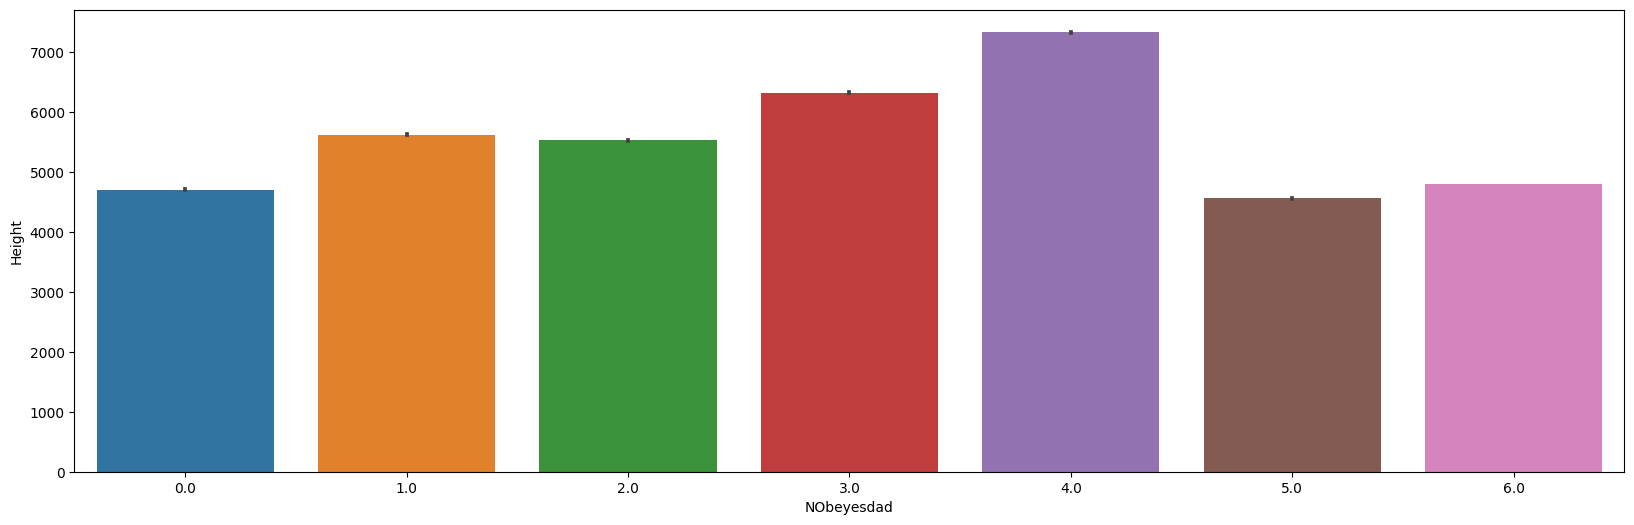



Feature: Weight


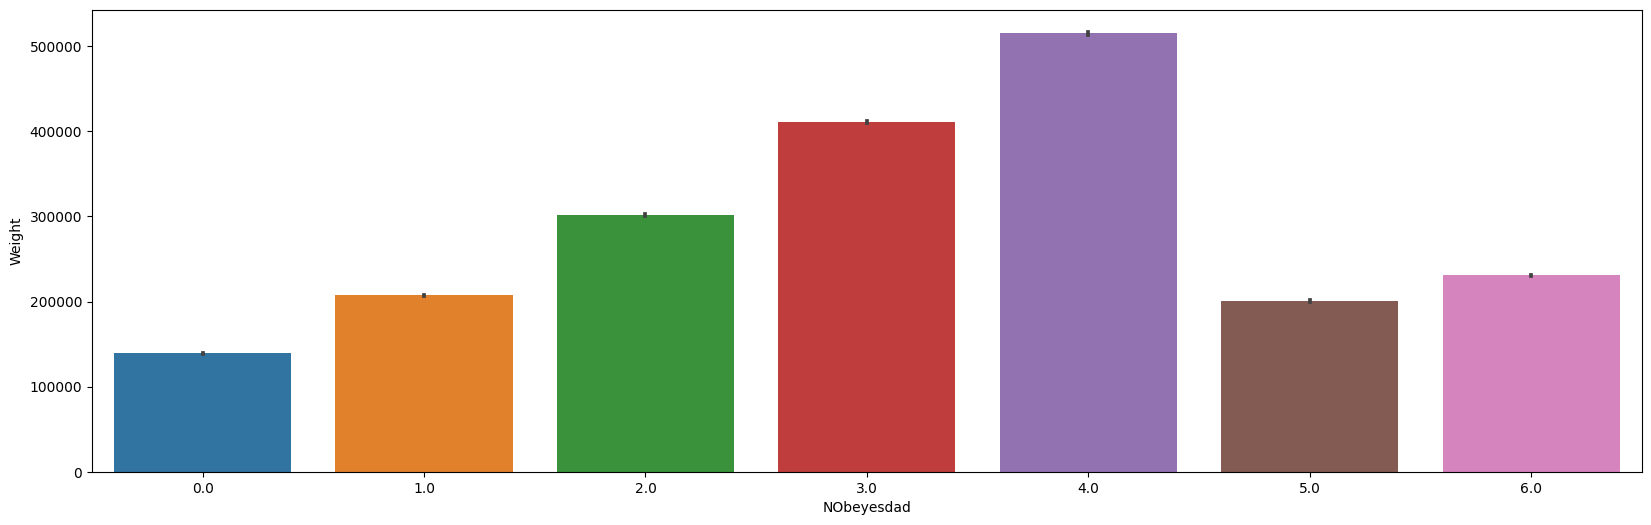



Feature: FCVC


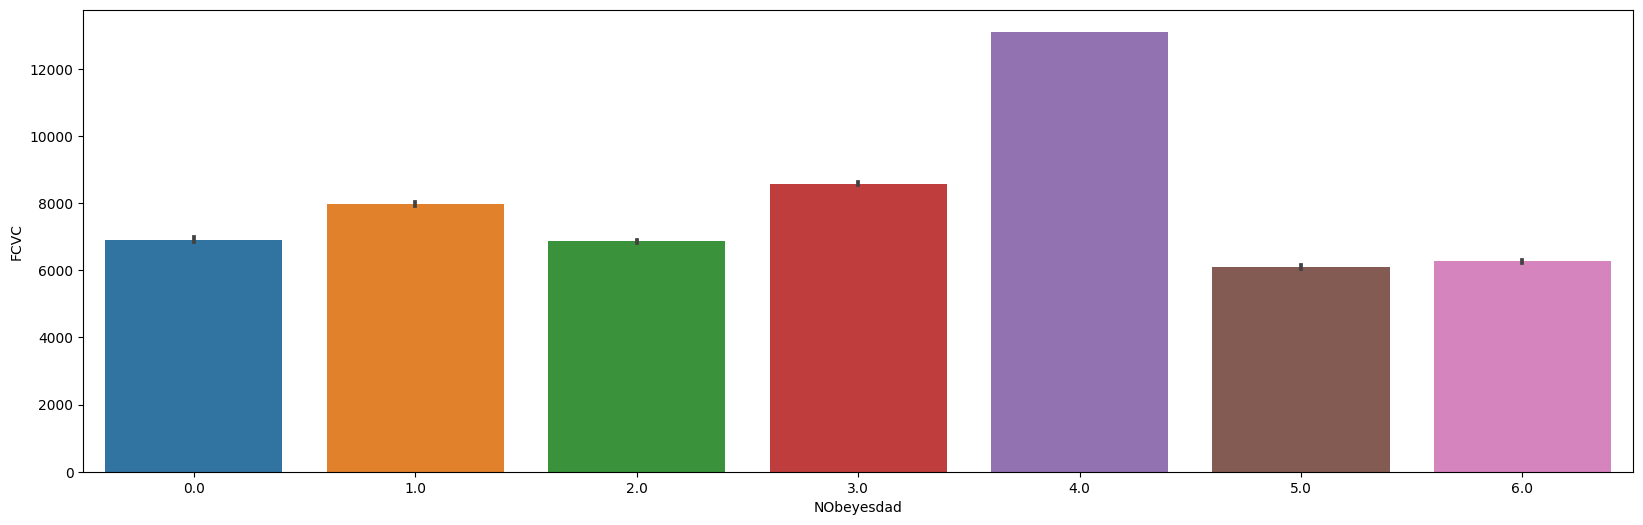



Feature: NCP


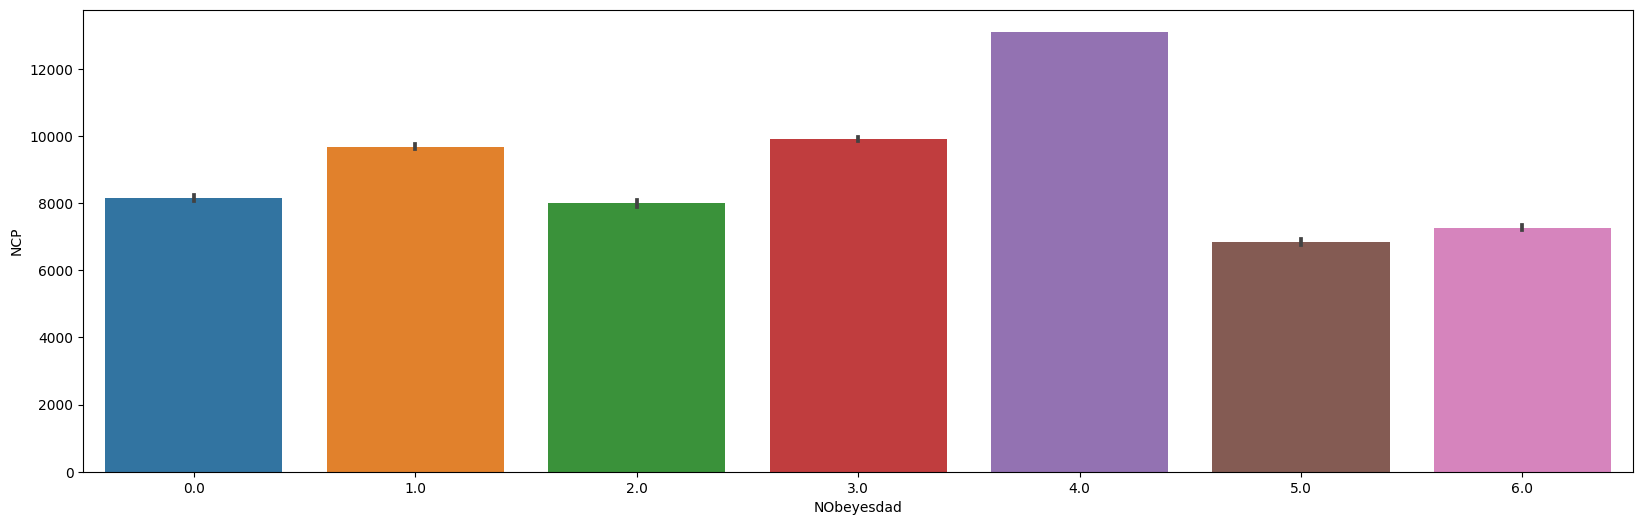



Feature: CH2O


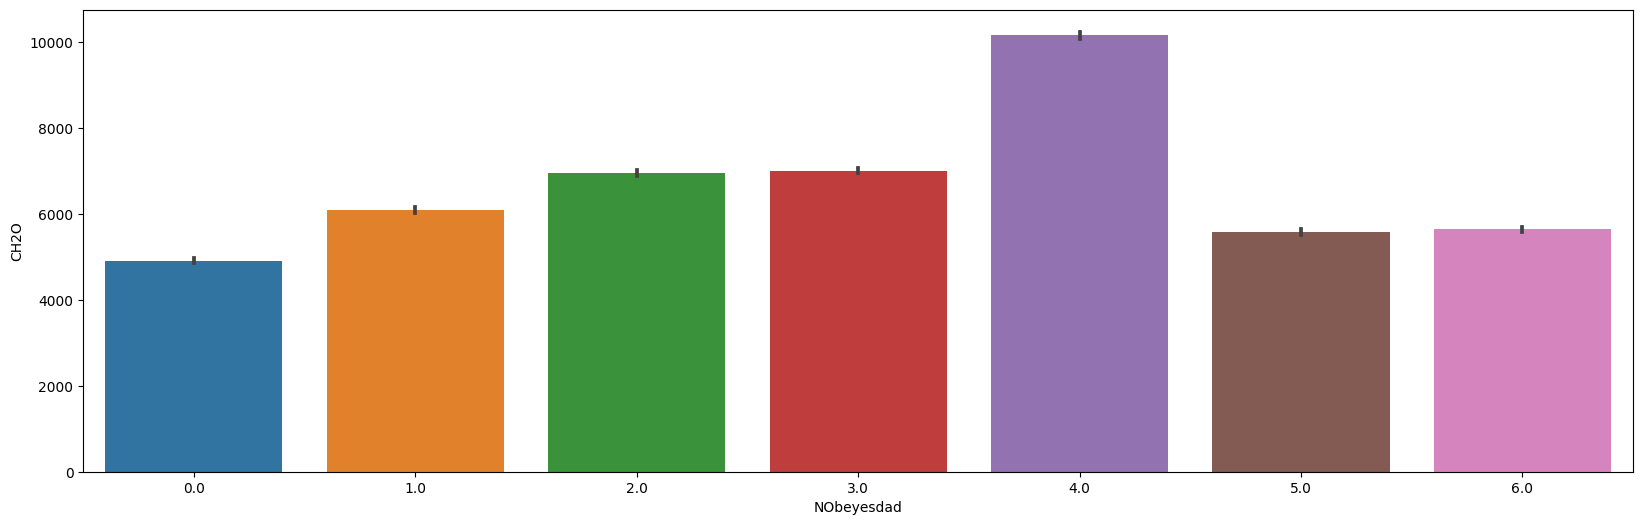



Feature: FAF


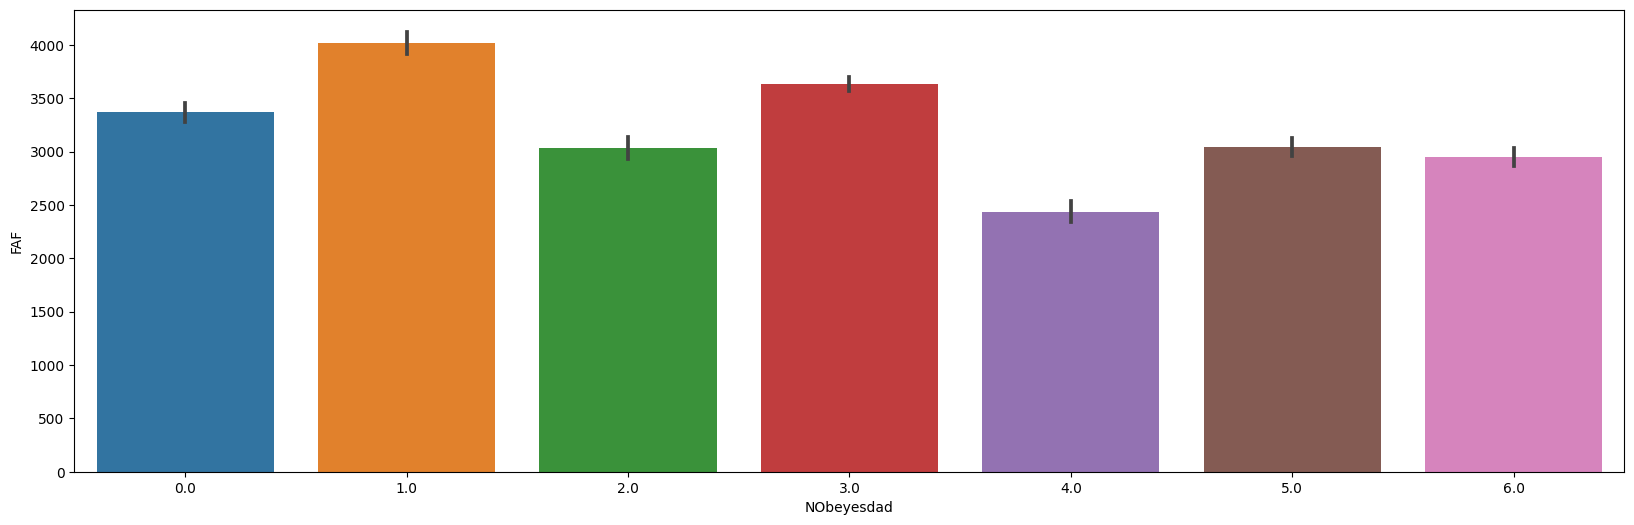



Feature: TUE


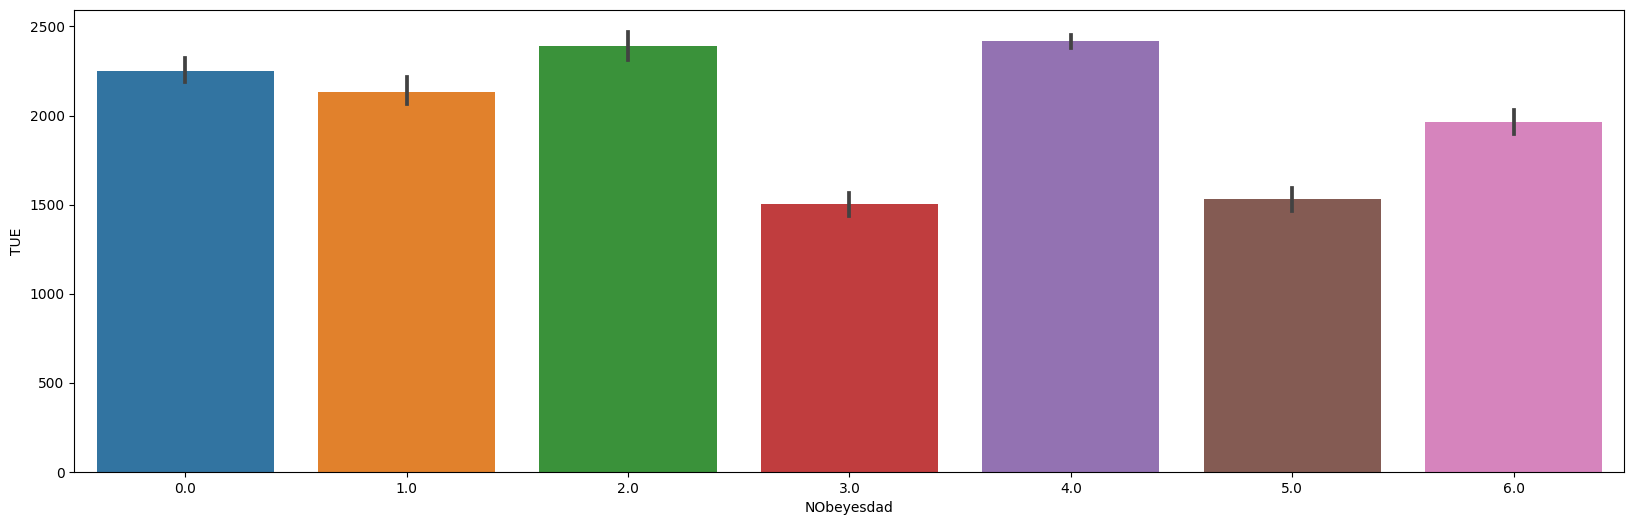

In [25]:
for feature in continuous_features:
    plt.figure(figsize=(20, 6))
    print(f'\n\nFeature: {feature}')
    sns.barplot(data=train, x=train[target], y=train[feature], estimator='sum')
    plt.show();

<a id='8'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍟 8 - Display histograms of distribution</span>

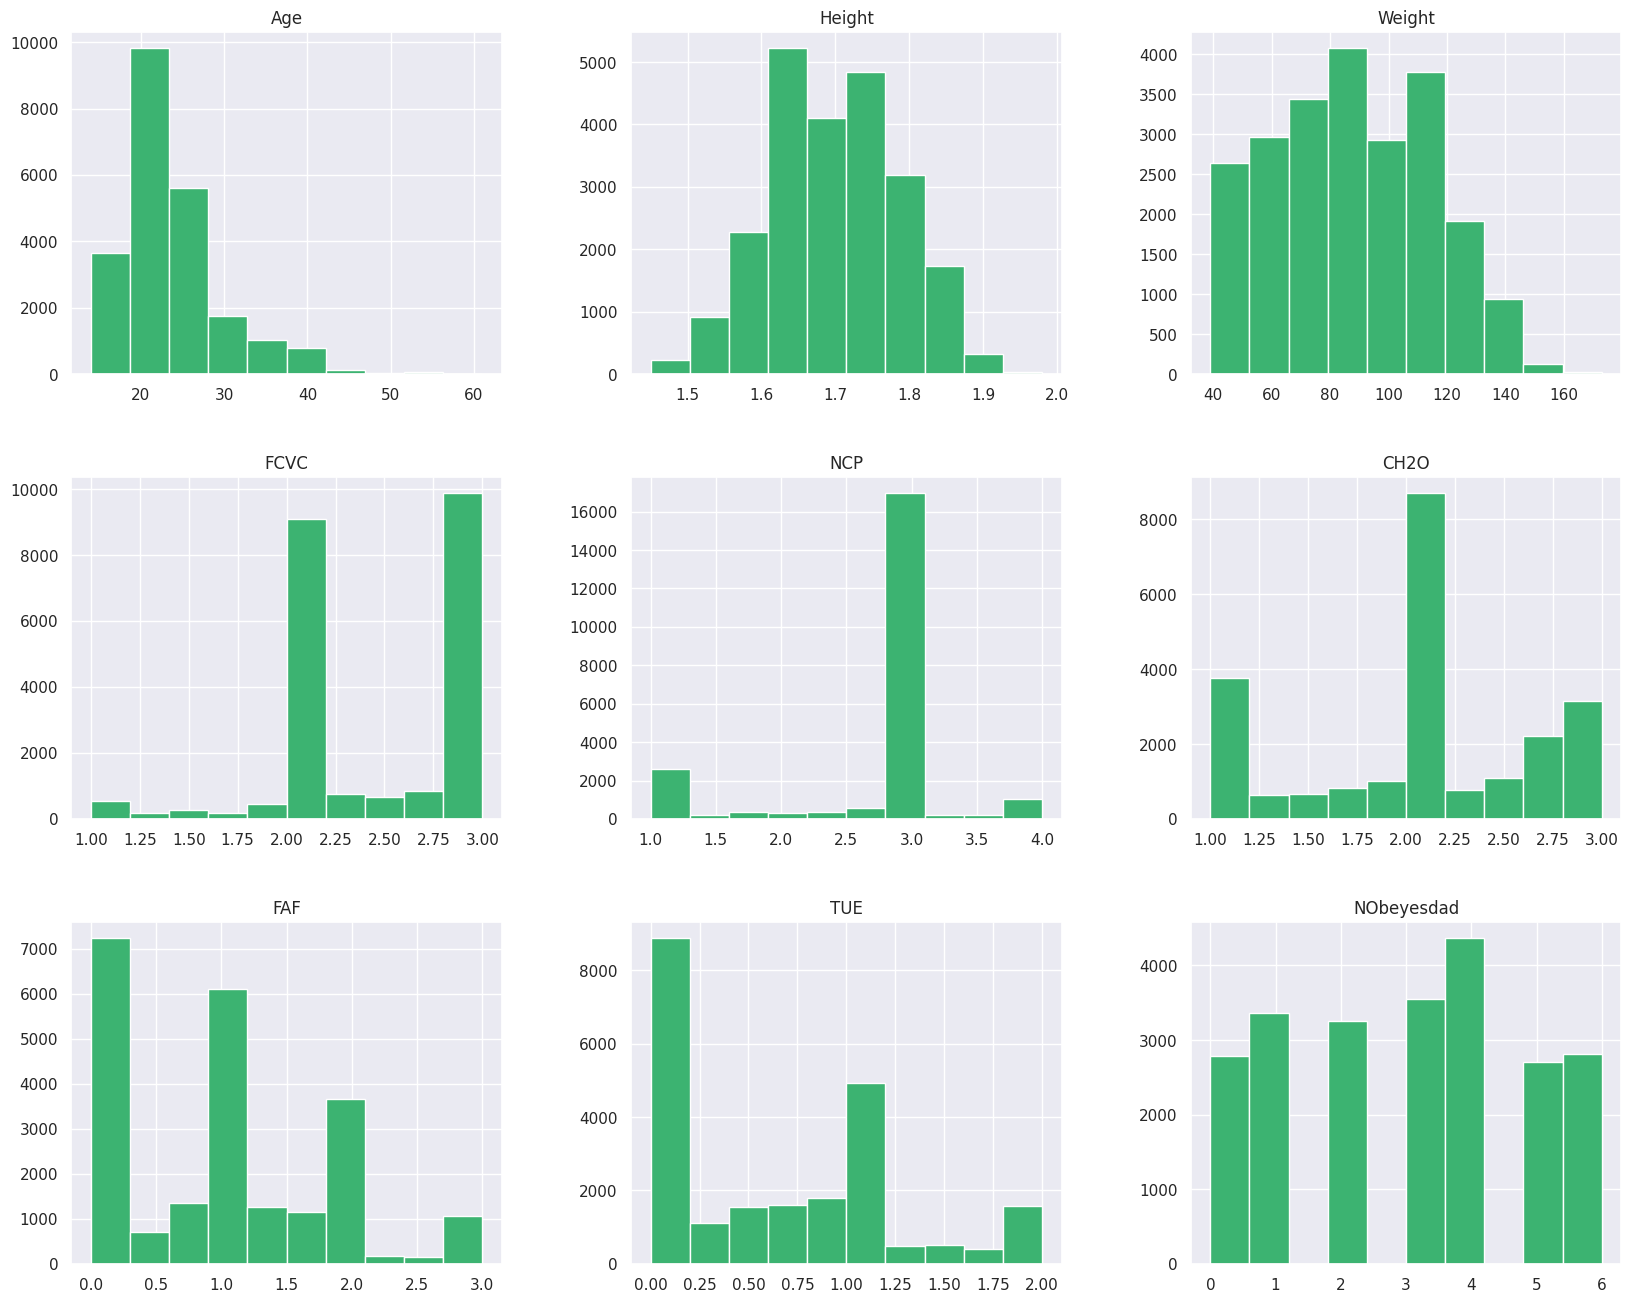

In [26]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='#3cb371');

<a id='9'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌭 9 - Let's count target of train data</span>

In [27]:
print(f'{y.value_counts()}\n\n')
print(y.value_counts() / y.shape[0])

NObeyesdad
4.0    4370
3.0    3545
1.0    3364
2.0    3261
6.0    2812
0.0    2790
5.0    2703
Name: count, dtype: int64


NObeyesdad
4.0    0.191289
3.0    0.155176
1.0    0.147253
2.0    0.142745
6.0    0.123090
0.0    0.122127
5.0    0.118319
Name: count, dtype: float64


##### Target classes are inbalanced

![](https://t3.ftcdn.net/jpg/01/96/93/78/360_F_196937881_vjymUgqEubdsT1QBzirUuN6GC331DJwy.jpg)

<a id='10'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌮 10 - Transform the data with Min-Max Scaler</span>

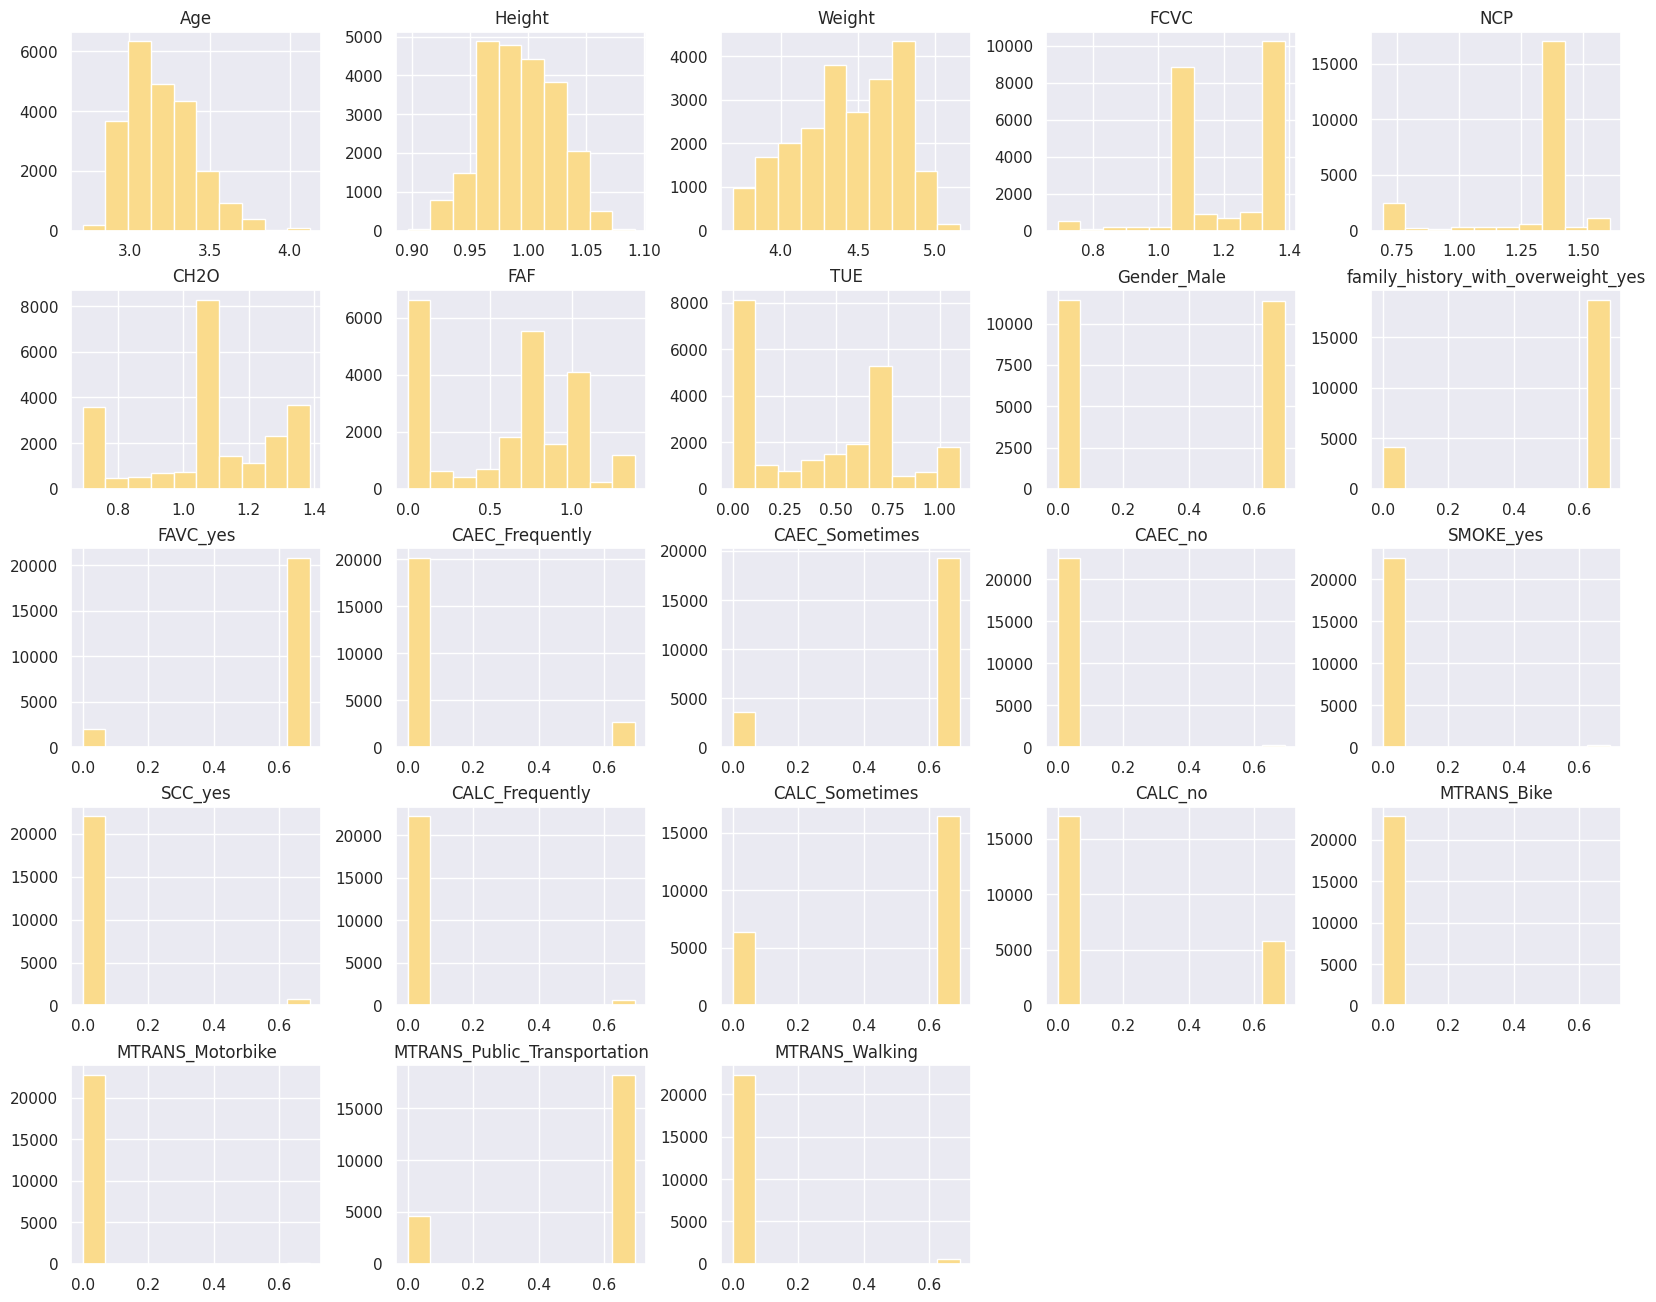

In [28]:
# In version 26 I decide to change log(x + 1) to log1p(x)
for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log1p(x))
    
# Transform test data
for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: np.log1p(x))
    
X.hist(color='#fadb8c');

<a id='10.1'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.1 - Pie plot of target</span>

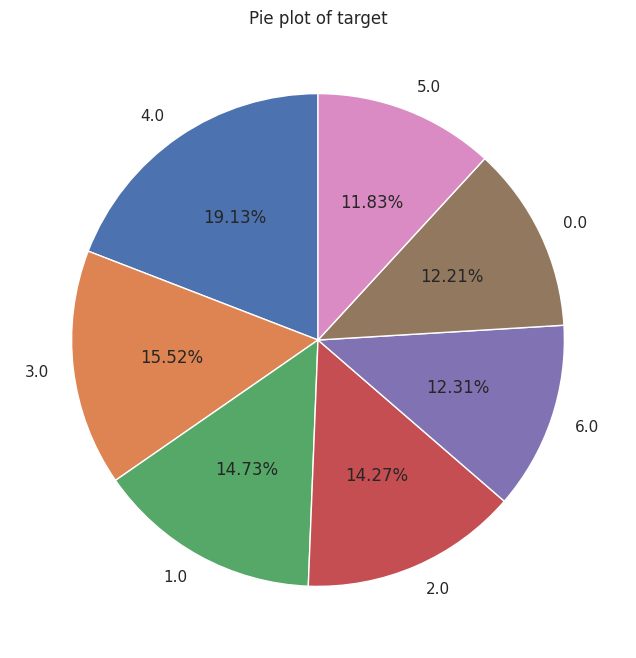

In [29]:
label_counts = y.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Pie plot of target')
plt.show();

<a id='10.2'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.2 Feature importance

In [30]:
X.isna().sum()

Age                                   0
Height                                0
Weight                                0
FCVC                                  0
NCP                                   0
CH2O                                  0
FAF                                   0
TUE                                   0
Gender_Male                           0
family_history_with_overweight_yes    0
FAVC_yes                              0
CAEC_Frequently                       0
CAEC_Sometimes                        0
CAEC_no                               0
SMOKE_yes                             0
SCC_yes                               0
CALC_Frequently                       0
CALC_Sometimes                        0
CALC_no                               0
MTRANS_Bike                           0
MTRANS_Motorbike                      0
MTRANS_Public_Transportation          0
MTRANS_Walking                        0
dtype: int64

CPU times: user 19.4 s, sys: 482 ms, total: 19.9 s
Wall time: 19.9 s


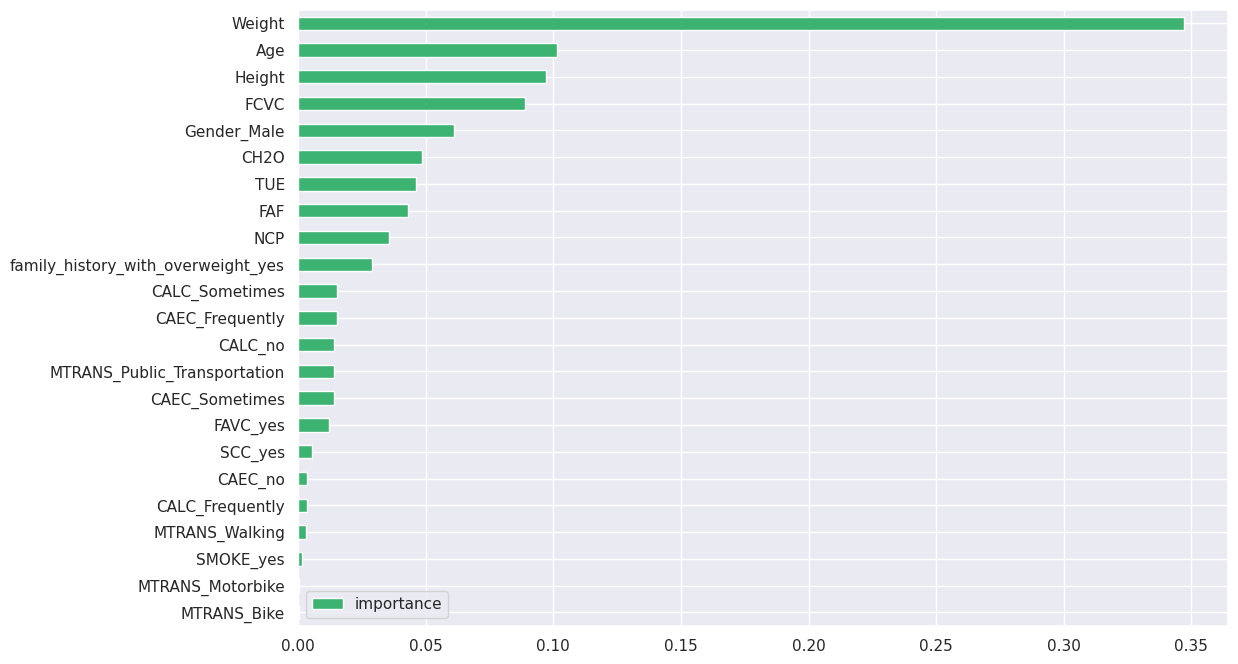

In [31]:
%%time
best_rf = RandomForestClassifier(
    n_estimators=518,
    criterion='gini',
    min_samples_leaf=1,
    max_depth=73,
    min_samples_split=2,
    random_state=27,  
)
    
best_rf.fit(X, y)
importance = best_rf.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

In [32]:
# Remove the 7 least significant features
useless_features = feature_importance[:7].index
print(useless_features)

X.drop(columns=useless_features, axis=1, inplace=True)
test.drop(columns=useless_features, axis=1, inplace=True)

Index(['MTRANS_Bike', 'MTRANS_Motorbike', 'SMOKE_yes', 'MTRANS_Walking',
       'CALC_Frequently', 'CAEC_no', 'SCC_yes'],
      dtype='object')


In [33]:
X.columns.tolist()

['Age',
 'Height',
 'Weight',
 'FCVC',
 'NCP',
 'CH2O',
 'FAF',
 'TUE',
 'Gender_Male',
 'family_history_with_overweight_yes',
 'FAVC_yes',
 'CAEC_Frequently',
 'CAEC_Sometimes',
 'CALC_Sometimes',
 'CALC_no',
 'MTRANS_Public_Transportation']

<a id='11'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌯 11 - Build a heat map of correlations</span>

In [34]:
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CALC_Sometimes,CALC_no,MTRANS_Public_Transportation
Age,1.000000,-0.002534,0.364461,0.062079,-0.028140,0.002281,-0.218442,-0.316608,0.066245,0.284378,0.067936,-0.196201,0.211425,0.068689,-0.083600,-0.508627
Height,-0.002534,1.000000,0.423230,-0.060001,0.204956,0.201143,0.328911,0.081506,0.623832,0.230706,0.123402,-0.110082,0.128937,0.070876,-0.087594,-0.069506
Weight,0.364461,0.423230,1.000000,0.197595,0.113102,0.309782,-0.076235,-0.052234,0.166649,0.549612,0.232472,-0.429391,0.448622,0.232108,-0.228634,0.015010
FCVC,0.062079,-0.060001,0.197595,1.000000,0.105560,0.088896,-0.079826,-0.113905,-0.286542,0.052629,0.002584,0.012063,0.025459,0.144070,-0.136038,0.080615
NCP,-0.028140,0.204956,0.113102,0.105560,1.000000,0.090267,0.078031,0.080834,0.049811,0.065960,0.016002,0.030803,0.002827,0.117077,-0.117366,-0.023783
CH2O,0.002281,0.201143,0.309782,0.088896,0.090267,1.000000,0.078412,0.010635,0.071760,0.195286,0.036912,-0.155880,0.129290,0.084251,-0.088748,0.051277
FAF,-0.218442,0.328911,-0.076235,-0.079826,0.078031,0.078412,1.000000,0.004352,0.259635,-0.088204,-0.060755,0.078025,-0.093507,-0.122812,0.109026,-0.033790
TUE,-0.316608,0.081506,-0.052234,-0.113905,0.080834,0.010635,0.004352,1.000000,0.030412,0.014485,0.052078,0.019209,-0.000968,-0.073039,0.067865,0.173169
Gender_Male,0.066245,0.623832,0.166649,-0.286542,0.049811,0.071760,0.259635,0.030412,1.000000,0.097399,0.025739,-0.072019,0.050267,-0.075287,0.057986,-0.167653
family_history_with_overweight_yes,0.284378,0.230706,0.549612,0.052629,0.065960,0.195286,-0.088204,0.014485,0.097399,1.000000,0.158143,-0.292619,0.323084,0.007373,-0.001039,-0.059506


##### There is no features with strong correlation

<a id='12'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥩 12 - Define base models with tuned hyperparameters</span>

# Optuna for hyperparameters optimization

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">Random Forest</span>

In [35]:
# %%time
# def objective(trial):
#     model = RandomForestClassifier(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         criterion=trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
#         min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         min_samples_split=trial.suggest_int("min_samples_split", 2, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return accuracy_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

""" Version 26
Number of finished trials:  100
Best trial:
  Value:  0.9043554388268767
  Params: 
    n_estimators: 198
    criterion: gini
    min_samples_leaf: 1
    max_depth: 71
    min_samples_split: 4

CPU times: user 34min 23s, sys: 3.67 s, total: 34min 26s
Wall time: 34min 29s
"""

' Version 26\nNumber of finished trials:  100\nBest trial:\n  Value:  0.9043554388268767\n  Params: \n    n_estimators: 198\n    criterion: gini\n    min_samples_leaf: 1\n    max_depth: 71\n    min_samples_split: 4\n\nCPU times: user 34min 23s, sys: 3.67 s, total: 34min 26s\nWall time: 34min 29s\n'

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">CatBoost</span>

In [36]:
# %%time
# def objective(trial):
#     model = CatBoostClassifier(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 7, 16),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
# #         bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
# #         random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
# #         bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
# #         od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
# #         od_wait=trial.suggest_int("od_wait", 10, 50),
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return accuracy_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">LightGBM</span>

In [37]:
# %%time
# def objective(trial):
#     model = LGBMClassifier(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         objective='multiclass',
#         verbosity=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
# #         lambda_l1=trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
# #         lambda_l2=trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         num_leaves=trial.suggest_int('num_leaves', 2, 256),
# #         feature_fraction=trial.suggest_float('feature_fraction', 0.4, 1.0),
# #         bagging_fraction=trial.suggest_float('bagging_fraction', 0.4, 1.0),
# #         bagging_freq=trial.suggest_int('bagging_freq', 1, 7),
#         min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return accuracy_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">XGBoost</span>

In [38]:
# %%time
# def objective(trial):
#     model = XGBClassifier(
#         max_depth=trial.suggest_int('max_depth', 1, 100),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         n_estimators=trial.suggest_int('n_estimators', 50, 1000),
#         min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
#         gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         eval_metric='mlogloss',
#         use_label_encoder=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return accuracy_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

""" Version 26
Number of finished trials:  100
Best trial:
  Value:  0.9150798861895382
  Params: 
    max_depth: 53
    learning_rate: 0.018924446628844505
    n_estimators: 473
    min_child_weight: 9
    gamma: 0.012577276789149876
    subsample: 0.7255520601630708
    colsample_bytree: 0.43838443542806727
    reg_alpha: 0.02785625699849848
    reg_lambda: 0.00016361807233114732

CPU times: user 22min 21s, sys: 7.42 s, total: 22min 28s
Wall time: 22min 29s
"""

' Version 26\nNumber of finished trials:  100\nBest trial:\n  Value:  0.9150798861895382\n  Params: \n    max_depth: 53\n    learning_rate: 0.018924446628844505\n    n_estimators: 473\n    min_child_weight: 9\n    gamma: 0.012577276789149876\n    subsample: 0.7255520601630708\n    colsample_bytree: 0.43838443542806727\n    reg_alpha: 0.02785625699849848\n    reg_lambda: 0.00016361807233114732\n\nCPU times: user 22min 21s, sys: 7.42 s, total: 22min 28s\nWall time: 22min 29s\n'

In [39]:
base_models = [
    ('catboost', CatBoostClassifier(
        iterations=438,
        learning_rate=0.06355240100441942,
        colsample_bylevel=0.7798817218618148,
        min_data_in_leaf=65,
        depth=7,
        l2_leaf_reg=0.002940223040033536,
        bootstrap_type='Bayesian',
        random_strength=0.00010916751893684645,
        bagging_temperature=0.7168126279416569,
        od_type='Iter',
        od_wait=23,
        random_state=27,
    )),
    ('xgboost', XGBClassifier(
        max_depth=53,
        learning_rate=0.018924446628844505,
        n_estimators=473,
        min_child_weight=9,
        gamma=0.012577276789149876,
        subsample=0.7255520601630708,
        colsample_bytree=0.43838443542806727,
        reg_alpha=0.02785625699849848,
        reg_lambda=0.00016361807233114732,
        random_state=27,
    )),
    ('lightgbm', LGBMClassifier(
        iterations=608,
        max_depth=35,
        learning_rate=0.017193151439794163,
        lambda_l1=2.599236784827289e-08,
        lambda_l2=0.0011382149342135629,
        num_leaves=133,
        feature_fraction=0.49481972850786726,
        bagging_fraction=0.4383271516736843,
        bagging_freq=3,
        min_child_samples=36,
        random_state=27
    )),
    ('random_forest', RandomForestClassifier(
        n_estimators=328,
        criterion='log_loss',
        min_samples_leaf=3,
        max_depth=26,
        min_samples_split=15,
        random_state=27,  
    )),
]

<a id='13'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍩 13 - Defining the meta-model with tuned hyperparameters</span>

In [40]:
meta_model = CatBoostClassifier(
    iterations=438,
    learning_rate=0.06355240100441942,
    colsample_bylevel=0.7798817218618148,
    min_data_in_leaf=65,
    depth=7,
    l2_leaf_reg=0.002940223040033536,
    bootstrap_type='Bayesian',
    random_strength=0.00010916751893684645,
    bagging_temperature=0.7168126279416569,
    od_type='Iter',
    od_wait=23,
    random_state=27,
)

<a id='14'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥗 14 - Creating and fitting the stacking model

![](https://qph.cf2.quoracdn.net/main-qimg-7f38ef83c49e23f246b792bf45f90ec1-lq)

In [41]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

print('Version 20: Validation Accuracy Score: 0.96104180')

0:	learn: 1.7186445	total: 124ms	remaining: 54s
1:	learn: 1.5592049	total: 167ms	remaining: 36.5s
2:	learn: 1.4320606	total: 205ms	remaining: 29.7s
3:	learn: 1.3298437	total: 242ms	remaining: 26.3s
4:	learn: 1.2445900	total: 278ms	remaining: 24.1s
5:	learn: 1.1736449	total: 317ms	remaining: 22.8s
6:	learn: 1.1065082	total: 356ms	remaining: 21.9s
7:	learn: 1.0447998	total: 392ms	remaining: 21.1s
8:	learn: 0.9934157	total: 431ms	remaining: 20.6s
9:	learn: 0.9474931	total: 467ms	remaining: 20s
10:	learn: 0.9053041	total: 508ms	remaining: 19.7s
11:	learn: 0.8666178	total: 546ms	remaining: 19.4s
12:	learn: 0.8309304	total: 585ms	remaining: 19.1s
13:	learn: 0.7978623	total: 619ms	remaining: 18.8s
14:	learn: 0.7670660	total: 658ms	remaining: 18.6s
15:	learn: 0.7402154	total: 694ms	remaining: 18.3s
16:	learn: 0.7137616	total: 734ms	remaining: 18.2s
17:	learn: 0.6901056	total: 773ms	remaining: 18s
18:	learn: 0.6669994	total: 811ms	remaining: 17.9s
19:	learn: 0.6461983	total: 848ms	remaining: 17

<a id='15'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍺 15 - Predict the validation set and calculate accuracy score</span>

In [42]:
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy Score: {accuracy_val:.8f}")

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.49481972850786726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49481972850786726
[LightGBM] [Warning] lambda_l2 is set=0.0011382149342135629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011382149342135629
[LightGBM] [Warning] lambda_l1 is set=2.599236784827289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599236784827289e-08
[LightGBM] [Warning] bagging_fraction is set=0.4383271516736843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4383271516736843
Validation Accuracy Score: 0.95206829


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<a id='16'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🫐 16 - Predict the test data</span>

In [43]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.49481972850786726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49481972850786726
[LightGBM] [Warning] lambda_l2 is set=0.0011382149342135629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011382149342135629
[LightGBM] [Warning] lambda_l1 is set=2.599236784827289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599236784827289e-08
[LightGBM] [Warning] bagging_fraction is set=0.4383271516736843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4383271516736843


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3., 5., 4., 2., 4., 0., 0., 1., 6., 1.])

In [44]:
result = np.ravel(enc.inverse_transform(y_pred_test.reshape(-1, 1)))
result[:10]

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III',
       'Obesity_Type_I', 'Obesity_Type_III', 'Insufficient_Weight',
       'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_II',
       'Normal_Weight'], dtype=object)

<a id='17'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍉 17 - Build DataFrame and make submission</span>

In [45]:
submission = pd.DataFrame({
    'id': submission_id,
    'NObeyesdad': result
})

submission.to_csv('Kapturov_S4E2_submission.csv', index=False)
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


<a id='18'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">💽 18 - Save the model into pickle file</span>

In [46]:
pickle.dump(stacking_model, open("Kapturov_stacking_model.pkl", "wb"))

# <span style="color: #03adfc">🏋️‍♀️😀 Hope You are feeling Yourself great!</span>